### Download and import packages
Download keras-contrib for CyclicLR and santander_helper for auc metric and custom Datagenerator

In [0]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git
! wget https://github.com/jganzabal/santander_kaggle_solutions_tests/raw/master/santander_helper.py

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-nna2erto
  Stored in directory: /tmp/pip-ephem-wheel-cache-yw7ir6ns/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
--2020-02-27 00:52:01--  https://github.com/jganzabal/santander_kaggle_solutions_tests/raw/master/santander_helper.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jganzabal/santander_kaggle_solutions_tests/master/santander_helper.py [following]
--2020-02-27 00:52:01--  https://raw.githubusercontent.com/jganzabal/santander_kaggle_solutions_tests/master/santander_helper.py
Resolving raw.githubusercontent.com (raw.githubusercont

In [0]:
import pandas as pd
import numpy as np
import gc
from santander_helper import auc, DataGenerator

from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold, StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam
from keras_contrib.callbacks import CyclicLR

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Divide fake datasets from real


In [0]:
# GET INDICIES OF REAL TEST DATA FOR FEATURE ENGINEERING.

test_path = '../input/test.csv'
train_path = '../input/train.csv'

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv('../input/train.csv', dtype=d)
test = pd.read_csv('../input/test.csv', dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')
print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv(train_path, dtype=d)
test = pd.read_csv(test_path, dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')

Found 100000 real test
Found 100000 fake test
Loaded 200000 rows of train
Loaded 200000 rows of test
Found 100000 real test
Found 100000 fake test
Loaded 200000 rows of train
Loaded 200000 rows of test


### Add counts to each of the 200 vars

In [0]:
# FREQUENCY ENCODE
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

test['target'] = -1
comb = pd.concat([train,test.loc[real_samples_indexes]],axis=0,sort=True)
for i in range(200): 
    encode_FE(comb,'var_'+str(i),test)
train = comb[:len(train)]; del comb
print('Added 200 new magic features!')

Added 200 new magic features!


In [0]:
del df_test, real_samples_indexes, synthetic_samples_indexes, unique_count, unique_samples, d
gc.collect()

238

### Load and prepare data for CNN

In [0]:
# Load data with counts saved in the previous cells
df_train_data = train.drop(columns=['ID_code'])
y = df_train_data['target'].values
df_train_X = df_train_data.drop(columns=['target'])

In [0]:
reverse_columns = True
if reverse_columns:
    reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                    27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                    62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                    95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                    130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                    159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                    180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,
                    ]

    for j in reverse_list:
        df_train_X[f'var_{j}'] *= -1

In [0]:
# Normalize data
means = df_train_X.mean(axis=0)
stds = df_train_X.std(axis=0)
df_train_X_normalized = (df_train_X - means)/stds

In [0]:
# Prepare data for CNN
X_train_normalized = np.zeros((df_train_X_normalized.shape[0], 400, 1))
for i in range(200):
    X_train_normalized[:, 2*i] = df_train_X_normalized[[f'var_{i}']].values #[indexes]
    X_train_normalized[:, 2*i+1] = df_train_X_normalized[[f'var_{i}_FE']].values #[indexes]

### CNN model

In [0]:
# Define model
def get_model(N_units = 600, kernel_size=2, strides=2):
    model = Sequential()
    model.add(Conv1D(N_units, kernel_size=kernel_size, strides=strides, padding='valid', 
                     activation='relu', input_shape=(X_train_normalized.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 600)          1800      
_________________________________________________________________
flatten_1 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 120001    
Total params: 121,801
Trainable params: 121,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
del df_train_data, df_train_X
gc.collect()

55

### Train model

In [0]:
best_model_file_name = 'best_full_model_aux.hdf5'
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
patience = 18
epochs = 100
bs = 512
N_units = 600
common_rows = 2
class_0_aug = 4
class_1_aug = 6

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train_X_normalized, y)):
    print('###############################################')
    print(f'##################Fold {fold}#######################')
    print('###############################################')
    model = get_model(N_units)
    model.compile(Adam(), loss='binary_crossentropy', metrics=[auc, 'accuracy'])
    es = EarlyStopping(monitor='val_auc', patience=patience, mode='max', verbose=1)
    mc = ModelCheckpoint(best_model_file_name, monitor='val_auc', mode='max', verbose=1, save_best_only=True)
 
    generator = DataGenerator(X_train_normalized[trn_idx], y[trn_idx], 
                              batch_size=bs, shuffle=True, 
                              class_1_aug=class_1_aug, 
                              class_0_aug=class_0_aug,
                              common_rows = common_rows
                             )
    tr_iter_in_epoch = generator.__len__()
#     gamma = 1 - 6e-05  * 4*312/tr_iter_in_epoch
#     clr = CyclicLR(base_lr=0.0001, max_lr=0.005, step_size=4*tr_iter_in_epoch, mode='exp_range', gamma=gamma)
    clr = CyclicLR(base_lr=0.0001, max_lr=0.005, step_size=4*tr_iter_in_epoch, mode='triangular2')
    X_val_data, y_val_data = DataGenerator.augment(X_train_normalized[val_idx], 
                                     y[val_idx], class_1_aug=class_1_aug//2, class_0_aug=class_0_aug//2, common_rows = common_rows)
    indexes_val = np.arange(len(y_val_data))
    np.random.shuffle(indexes_val)
    model.fit_generator(generator,
              epochs=epochs,
              verbose=2,
              callbacks = [es, 
                           mc, 
                           clr],
              validation_data=(X_val_data[indexes_val], y_val_data[indexes_val])
                )
    # print(f'Finish training with lr {lr}')
    model = get_model()
    # Load weights from ModelCheckpoint
    model.load_weights(best_model_file_name)
    # Save them to disk
    model.save_weights(f'CNN_generator_fold_{fold}_cl1_{class_1_aug}_cl0_{class_0_aug}_{N_units}.hdf5')

###############################################
##################Fold 0#######################
###############################################
Epoch 1/100
 - 31s - loss: 0.2749 - auc: 0.8750 - acc: 0.8918 - val_loss: 0.2631 - val_auc: 0.9003 - val_acc: 0.8957

Epoch 00001: val_auc improved from -inf to 0.90030, saving model to best_full_model_aux.hdf5
Epoch 2/100
 - 51s - loss: 0.2400 - auc: 0.9115 - acc: 0.9061 - val_loss: 0.2467 - val_auc: 0.9101 - val_acc: 0.9045

Epoch 00002: val_auc improved from 0.90030 to 0.91005, saving model to best_full_model_aux.hdf5
Epoch 3/100
 - 51s - loss: 0.2320 - auc: 0.9181 - acc: 0.9097 - val_loss: 0.2357 - val_auc: 0.9148 - val_acc: 0.9079

Epoch 00003: val_auc improved from 0.91005 to 0.91485, saving model to best_full_model_aux.hdf5
Epoch 4/100
 - 50s - loss: 0.2296 - auc: 0.9200 - acc: 0.9104 - val_loss: 0.2281 - val_auc: 0.9155 - val_acc: 0.9111

Epoch 00004: val_auc improved from 0.91485 to 0.91553, saving model to best_full_model_aux.hdf5
Epo

### Evaluate Model

In [0]:
df_test = test.drop(columns=['ID_code', 'target'])
if reverse_columns:
    for j in reverse_list:
        df_test[f'var_{j}'] *= -1
df_test_X_normalized = (df_test - means)/stds

In [0]:
X_test_normalized = np.zeros((df_test_X_normalized.shape[0], 400, 1))
for i in range(200):
    X_test_normalized[:, 2*i] = df_test_X_normalized[[f'var_{i}']].values
    X_test_normalized[:, 2*i+1] = df_test_X_normalized[[f'var_{i}_FE']].values

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
full_val_preds = np.zeros((len(df_train_X_normalized), 1))
model = get_model(N_units)
test_predictions = 0
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train_X_normalized, y)):
    print('###############################################')
    print(f'##################Fold {fold}#######################')
    print('###############################################')
    X_train = X_train_normalized[trn_idx]
    X_val = X_train_normalized[val_idx]
    filename = f'CNN_generator_fold_{fold}_cl1_{class_1_aug}_cl0_{class_0_aug}_{N_units}.hdf5'
    model.load_weights(filename)
    full_val_preds[val_idx] = model.predict(X_val, verbose=1)
    print(roc_auc_score(y[val_idx], full_val_preds[val_idx]))
    test_predictions = test_predictions + model.predict(X_test_normalized, verbose=1)/5

###############################################
##################Fold 0#######################
###############################################
40001/40001 [==============================] - 3s 82us/step
0.9214917291201643
200000/200000 [==============================] - 15s 77us/step
###############################################
##################Fold 1#######################
###############################################
40001/40001 [==============================] - 3s 76us/step
0.9201218726411852
200000/200000 [==============================] - 15s 76us/step
###############################################
##################Fold 2#######################
###############################################
40000/40000 [==============================] - 3s 78us/step
0.9273897259118526
200000/200000 [==============================] - 16s 78us/step
###############################################
##################Fold 3#######################
##############################################

In [0]:
# Validation ROC AUC
roc_auc_score(y, full_val_preds)

0.9222195537206261

### Test data - log odds distribution

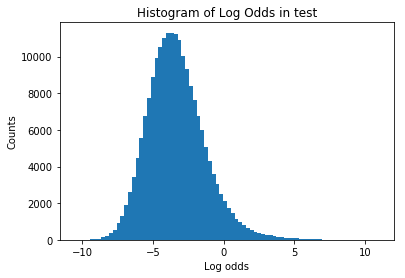

In [0]:
from matplotlib import pyplot as plt
_ = plt.hist(np.log(test_predictions/(1-test_predictions)), 80)
plt.title('Histogram of Log Odds in test')
plt.xlabel('Log odds')
plt.ylabel('Counts')
plt.show()

### Create submission file

In [0]:
def save_submit_file(predictions, filename, test_filename=test_path, index_column='ID_code', target_column = 'target'):
    df_test_submit = pd.read_csv(test_filename).set_index(index_column)
    df_test_submit[target_column] = predictions
    df_test_submit[[target_column]].to_csv(filename)
    return 

In [0]:
save_submit_file(test_predictions, f'submit_CNN_generator_cl1_{class_1_aug}_cl0_{class_0_aug}_{N_units}.csv')

### Leaderboard Scores
- **Public**: 0.92209
- **Private**: 0.92159